In [1]:
from copy import deepcopy
from pathlib import Path
import os
import pickle
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import skimage
import seaborn as sns
import tifffile
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.multiplex as multiplex
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.visualization.tiling_utils as tiling_utils

In [5]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1/')

In [6]:
os.listdir(project_dir)

['HT553P1-H2',
 'S18-25943-A7',
 'S18-5591-C8',
 'HT413C1-K2',
 'HT339B2-H1',
 'HT413C1-Th1k4A1',
 'kidney',
 'HT565B1-H2',
 'WD-76845',
 'analysis',
 'C3L-00970',
 'HT704B1',
 'C3L-00982',
 'HT225C1',
 'S18-9906',
 'HT268B1',
 'C3L-02551',
 'C3L-01287',
 'HT206B1',
 'HT448C1-Th1K1Fp1',
 'HT397B1']

In [42]:
multiplex_view_settings = [
    {
        'channel': 'Pan-Cytokeratin',
        'color': 'red',
        'min_value': 15,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DR',
        'color': 'magenta',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Keratin 14',
        'color': 'white',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'CD8',
        'color': 'green',
        'min_value': 20,
        'max_value': 75,
        'gamma': 1.
    },
    {
        'channel': 'CD45 (D)',
        'color': 'cyan',
        'min_value': 15,
        'max_value': 255,
        'gamma': 1.
    },
]

def get_multiplex_pseudo(fp, view_settings):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

xenium_view_settings = [
    {
        'channel': 'EPCAM',
        'color': 'red',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
    {
        'channel': 'HLA-DQB2',
        'color': 'magenta',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
    {
        'channel': 'ACTA2',
        'color': 'white',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
    {
        'channel': 'CD3E',
        'color': 'green',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
    {
        'channel': 'PTPRC',
        'color': 'yellow',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
]

def tile_xenium(adata, target_size=None, tile_size=20):
    if target_size is None:
        target_size = xenium.get_fullres_size(adata)
    
    adata.obs['grid_name'] = [f'{x // tile_size}_{y // tile_size}' for x, y in adata.obsm['spatial']]
    df = pd.DataFrame(data=adata.X, columns=adata.var.index.to_list(), index=adata.obs.index.to_list())
    df['grid_name'] = adata.obs['grid_name'].to_list()
    df = df.groupby('grid_name').sum()
    
    img = np.zeros((target_size[0] // tile_size + 1, target_size[1] // tile_size + 1, df.shape[1]))
    for name, row in df.iterrows():
        x, y = [int(x) for x in name.split('_')]
        img[y, x] = row.values
    return img
    

def get_xenium_pseudo(fp, view_settings, tile_size=20, target_size=None):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    adata = xenium.adata_from_xenium(fp)
    if target_size is None:
        target_size = xenium.get_fullres_size(adata)
    
    img = tile_xenium(adata, tile_size=tile_size)
    
    data = img[..., [adata.var.index.to_list().index(x) for x in channels]]
    data -= data.min((0, 1))
    data /= data.max((0, 1))
    data *= 255.
    data = data.astype(np.uint8)
    data = rearrange(data, 'h w c -> c h w')
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    rgb = utils.rescale(rgb, size=target_size, dim_order='h w c', target_dtype=rgb.dtype)
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
#     plt.imshow(rgb[4000:4500, 4000:4500])
#     plt.show()
    
    return rgb

In [8]:
cases = [
    'HT397B1',
    'HT206B1',
    'HT704B1'
]
case_to_config = {case:yaml.safe_load(open(project_dir / case / 'mushroom_50res' / 'config.yaml'))
                  for case in cases}

In [9]:
case_to_threshold = {
    'HT397B1': 45.,
    'HT206B1': 45.,
    'HT704B1': 45.
}


In [10]:
case = 'HT397B1'

In [11]:
case_to_config[case]['sections']

[{'data': [{'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium.h5ad'},
   {'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_he.tif'}],
  'position': 0,
  'sid': 'HT397B1-U1'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff'}],
  'position': 5,
  'sid': 'HT397B1-U2'},
 {'data': [{'dtype': 'batch2_he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he.tif'}],
  'position': 15,
  'sid': 'HT397B1-U4'},
 {'data': [{'dtype': 'batch2_he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8_batch2_he.tif'}],
  'position': 35,
  'sid': 'HT397B1-U8'},
 {'data': [{'dtype': 'batch2_he',
    'filepath': '/data/estorrs/mushroom/data/projects/subm

In [12]:
fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium.h5ad'
adata = xenium.adata_from_xenium(fp)
adata

AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial'
    obsm: 'spatial'

In [13]:
tiling_size = 100

In [14]:
target_size = [int(x) for x in np.asarray(xenium.get_fullres_size(adata)) / tiling_size]
target_size

[186, 183]

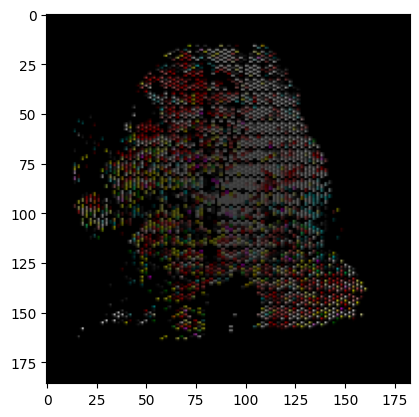

In [15]:
pseudo = get_xenium_pseudo(fp, xenium_view_settings, tile_size=tiling_size, target_size=target_size)
plt.imshow(pseudo)

In [44]:
fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex.ome.tiff'
size = multiplex.get_size(fp)[1:]
mpp = 1 / multiplex.pixels_per_micron(fp)
tiling_size = int(20 / mpp)
target_size = [int(x / tiling_size) for x in size]
tiling_size, target_size

(46, [405, 399])

In [45]:
# xenium_channels = [
#     'EPCAM', 'PTPRC', 'CD4', 'CD8A', 'MS4A1', 'CD68', 'CD163', 'ACTA2', 'PDPN', 'HLA-DQB2', 'LAG3', 'PDCD1', 'GZMB', 'PECAM1'
# ]
# xenium_tiled = tiling_utils.get_tiled_sections(
#     case_to_config[case], dtype='xenium', channel_names=xenium_channels,
#     tiling_size=tiling_size, target_size=target_size
# )
# xenium_tiled.shape

In [46]:
from scipy.ndimage import binary_fill_holes
def to_masks(tiled, thresh, index=0):
    masks = []
    for img in tiled[:, index]:
        mask = img > thresh
        mask = binary_fill_holes(mask)
        masks.append(mask)
    masks = np.stack(masks)
    return masks

In [47]:
# plt.imshow(xenium_tiled[0, 2] > 40)

In [48]:
# plt.imshow(xenium_tiled[0, 7] > 10)

In [49]:
# xenium_masks = to_masks(xenium_tiled, 10, index=0)
# plt.imshow(xenium_masks[0])

In [50]:
fps = [entry['data'][0]['filepath'] for entry in case_to_config[case]['sections']
                 if entry['data'][0]['dtype']=='multiplex']
multiplex_channels = multiplex.get_common_channels(fps)
multiplex_channels

['Bap1 (D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

In [51]:
multiplex_tiled = tiling_utils.get_tiled_sections(
    case_to_config[case], dtype='multiplex', channel_names=multiplex_channels,
    tiling_size=tiling_size, target_size=target_size
)
multiplex_tiled.shape

(4, 24, 405, 399)

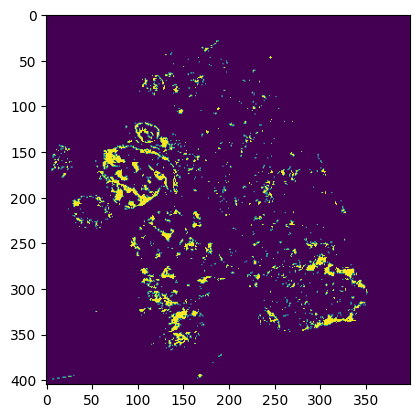

In [52]:
plt.imshow(multiplex_tiled[0, multiplex_channels.index('CD45 (D)')] > 7)

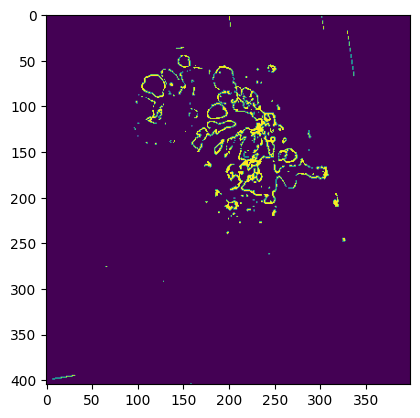

In [54]:
plt.imshow(multiplex_tiled[0, multiplex_channels.index('Keratin 14')] > 10)

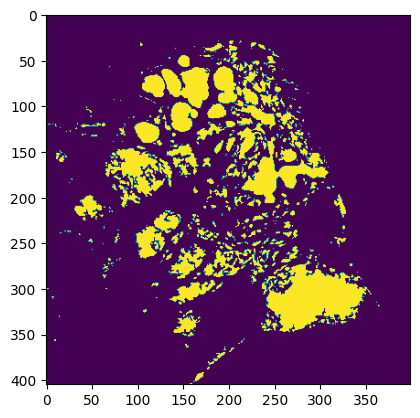

In [60]:
multiplex_masks = to_masks(multiplex_tiled, 70, index=multiplex_channels.index('Pan-Cytokeratin'))
plt.imshow(multiplex_masks[0])

In [61]:
# cosmx_tiled = tiling_utils.get_tiled_sections(
#     case_to_config['HT704B1'], dtype='cosmx', channel_names=['EPCAM', 'KRT5'],
#     tiling_size=20, target_size=target_size
# )
# cosmx_tiled.shape

In [62]:
# img = cosmx_tiled[0, 0].copy()
# mask = img>40
# mask = binary_fill_holes(mask)
# plt.imshow(mask)

In [139]:
# def to_stacked_rgb(config, dtype_to_masks, dtype_to_tiled, value_idx,
#                    dtype_to_vmax=50., spacing_scaler=10, squish_scaler=2):
#     target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
#     dtypes = dtype_to_masks.keys()
    
#     positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
#                                     for entry in config['sections']
#                                     if entry['data'][0]['dtype'] in dtypes])
    
#     sid_to_data = {}
#     for dtype in dtypes:
#         intensities = dtype_to_tiled[dtype]
#         masks = dtype_to_masks[dtype]
#         vmax = dtype_to_vmax if not isinstance(dtype_to_vmax, dict) else dtype_to_vmax[dtype]
#         ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
#         for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
#             rgb, props = to_cmapped_rgb(mask, intensity, value_idx, vmax=vmax)
#             sid_to_data[sid] = {
#                 'rgb': rgb,
#                 'position': position,
#                 'props': props
#             }

#     blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

#     blank = np.concatenate(
#         (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
#     )

#     for sid in sids:
#         data = sid_to_data[sid]
#         rgb = data['rgb']
#         position = data['position'] // spacing_scaler
#         size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
#         rgb = utils.rescale(rgb, size=size, dim_order='h w c')

#         # pad to size of blank with a translation
#         top = np.zeros((position, blank.shape[1], blank.shape[2]))
#         bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
#         padded = np.concatenate((top, rgb, bottom))

#         m = blank[..., -1] == 0
#         blank[m] = padded[m]

#     return blank, sid_to_data

In [143]:
from skimage.measure import regionprops
from skimage.morphology import binary_erosion, binary_dilation

def to_cmapped_rgb_continuous(mask, tiled, idx, thresh,
                              boundary_dist=1, external_dist=4, method='region',
                              cmap=None, min_area=4, vmax=1.):
    img = tiled[idx]
    
    if cmap is None:
        cmap = sns.color_palette('viridis', n_colors=int(100 * vmax) + 1)
    else:
        cmap = sns.color_palette(cmap, n_colors=int(100 * vmax) + 1)
    
    labeled = skimage.morphology.label(mask)
    print(labeled.shape, img.shape)
    props = regionprops(labeled, img)
    props = [p for p in props if p.area >= min_area]
    
    blank = np.ones((labeled.shape[0], labeled.shape[1], 4), dtype=np.float32)
    blank[..., -1] = 0.
    meta = {}
    for p in props:
        r1, c1, r2, c2 = p.bbox
        r1 = max(0, r1 - external_dist)
        c1 = max(0, c1 - external_dist)
        r2 = min(labeled.shape[0] - 1, r2 + external_dist)
        c2 = min(labeled.shape[1] - 1, c2 + external_dist)
        
        initial = labeled[r1:r2, c1:c2] == p.label
        
        eroded = initial.copy()
        for i in range(int(boundary_dist)):
            eroded = binary_erosion(eroded)
        expanded = initial.copy()
        for i in range(int(boundary_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        boundary_mask = expanded ^ eroded
        
        expanded = initial.copy()
        for i in range(int(external_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        external_mask = expanded ^ initial
        
        region_img = tiled[:, r1:r2, c1:c2]
        
        boundary_means = region_img[:, boundary_mask].mean(-1)
        internal_means = region_img[:, initial].mean(-1)
        external_means = region_img[:, external_mask].mean(-1)

        if method == 'region':
            m = initial
        elif method == 'external':
            m = external_mask
        elif method == 'boundary':
            m = boundary_mask
        else:
            raise RuntimeError(f'invalid method {method}')

        pixels = region_img[idx, m]
        frac = np.count_nonzero(pixels > thresh) / len(pixels)
        
        color = cmap[min(int(vmax * 100), int(frac * 100))]
        color = np.asarray([*color, 1.])

        tile = blank[r1:r2, c1:c2]
        tile[initial] = color
        blank[r1:r2, c1:c2] = tile
        
        meta[p.label] = {
            'fraction': frac,
            'area': p.area,
            'bbox_actual': (r1, c1, r2, c2),
            'prop': p,
            'boundary_means': boundary_means,
            'internal_means': internal_means,
            'external_means': external_means
        }

    return blank, meta, labeled

def to_stacked_rgb_continuous(
        config, dtype_to_masks, dtype_to_tiled, dtype_to_channel_idxs, dtype_to_thresholds,
        boundary_dist=1, external_dist=4,
        spacing_scaler=10, squish_scaler=2,
        cmap=None, vmax=1., method='region', min_area=4.
    ):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        thresh = dtype_to_thresholds[dtype]
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            idx = dtype_to_channel_idxs[dtype]
            rgb, meta, labeled = to_cmapped_rgb_continuous(
                mask, intensity, idx, thresh,
                boundary_dist=boundary_dist, external_dist=external_dist,
                cmap=cmap, vmax=vmax, min_area=min_area, method=method
            )
            sid_to_data[sid] = {
                'dtype': dtype,
                'rgb': rgb,
                'position': position,
                'meta': meta,
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data


def to_cmapped_rgb_category(mask, tiled, myoepi_idx, immune_idx,
                            myoepi_thresh=100, immune_thresh=100, area_thresh=100,
                            boundary_dist=1, external_dist=4, cat_to_color=None, min_area=4):
    
    immune_img = tiled[immune_idx]
    myoepi_img = tiled[myoepi_idx]
    
    cmap = sns.color_palette('tab10')
    possibles = [f'my{x}_im{y}_a{z}' for x in [True, False] for y in [True, False] for z in [True, False]]
    if cat_to_color is None:
        cat_to_color = {x:c for x, c in zip(possibles, cmap)}
    
    labeled = skimage.morphology.label(mask)
    props = regionprops(labeled, myoepi_img)
    props = [p for p in props if p.area >= min_area]
    
    blank = np.ones((labeled.shape[0], labeled.shape[1], 4), dtype=np.float32)
    blank[..., -1] = 0.
    meta = {}
    for p in props:
        r1, c1, r2, c2 = p.bbox
        r1 = max(0, r1 - external_dist)
        c1 = max(0, c1 - external_dist)
        r2 = min(labeled.shape[0] - 1, r2 + external_dist)
        c2 = min(labeled.shape[1] - 1, c2 + external_dist)
        
        initial = labeled[r1:r2, c1:c2] == p.label
        
        eroded = initial.copy()
        for i in range(int(boundary_dist)):
            eroded = binary_erosion(eroded)
        expanded = initial.copy()
        for i in range(int(boundary_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        boundary_mask = expanded ^ eroded
        
        expanded = initial.copy()
        for i in range(int(external_dist)):
            expanded = skimage.morphology.binary_dilation(expanded)
        external_mask = expanded ^ initial
        
        region_img = tiled[:, r1:r2, c1:c2]
        
        boundary_means = region_img[:, boundary_mask].mean(-1)
        internal_means = region_img[:, initial].mean(-1)
        external_means = region_img[:, external_mask].mean(-1)
        
#         print(myoepi_idx, boundary_means)

        pixels = region_img[myoepi_idx, boundary_mask]
        myoepi_mean = np.count_nonzero(pixels > myoepi_thresh) / len(pixels)
        
        pixels = region_img[immune_idx, external_mask]
        immune_mean = np.count_nonzero(pixels > immune_thresh) / len(pixels)
        
        is_myoepi = myoepi_mean > .25
        is_immune = immune_mean > .20
        
        
#         myoepi_mean = boundary_means[myoepi_idx]
#         immune_mean = external_means[immune_idx]
        
#         is_myoepi = myoepi_mean > myoepi_thresh
#         is_immune = immune_mean > immune_thresh
        is_area = p.area > area_thresh
        
        cat = f'my{is_myoepi}_im{is_immune}_a{is_area}'
        color = cat_to_color[cat]
        color = np.asarray([*color, 1.])

        tile = blank[r1:r2, c1:c2]
        tile[initial] = color
        blank[r1:r2, c1:c2] = tile
        
        meta[p.label] = {
            'category': cat,
            'is_myoepi': is_myoepi,
            'is_immune': is_immune,
            'is_area': is_area,
            'myoepi_mean': myoepi_mean,
            'immune_mean': immune_mean,
            'area': p.area,
            'bbox_actual': (r1, c1, r2, c2),
            'prop': p,
            'boundary_means': boundary_means,
            'internal_means': internal_means,
            'external_means': external_means
        }

    return blank, meta, labeled, cat_to_color

def to_stacked_rgb_category(
        config, dtype_to_masks, dtype_to_tiled, dtype_to_channel_idxs, dtype_to_thresholds,
        boundary_dist=1, external_dist=4,
        spacing_scaler=10, squish_scaler=2,
        cat_to_color=None
    ):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        thresholds = dtype_to_thresholds[dtype]
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            myoepi_idx = dtype_to_channel_idxs[dtype]['myoepi']
            immune_idx = dtype_to_channel_idxs[dtype]['immune']
            rgb, meta, labeled, _ = to_cmapped_rgb_category(
                mask, intensity, myoepi_idx, immune_idx,
                myoepi_thresh=thresholds['myoepi_thresh'],
                immune_thresh=thresholds['immune_thresh'],
                area_thresh=thresholds['area_thresh'],
                boundary_dist=boundary_dist, external_dist=external_dist,
                cat_to_color=cat_to_color
            )
            sid_to_data[sid] = {
                'dtype': dtype,
                'rgb': rgb,
                'position': position,
                'meta': meta,
                'cat_to_color': cat_to_color
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


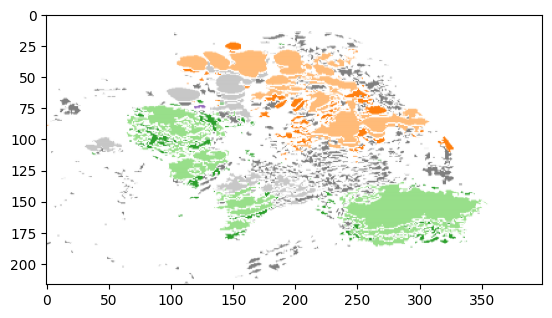

In [131]:
dtype_to_tiled = {
    'multiplex': multiplex_tiled,
#     'xenium': xenium_tiled
}
dtype_to_masks = {
    'multiplex': multiplex_masks,
#     'xenium': xenium_masks
}
dtype_to_thresholds = {
    'multiplex': {
        'myoepi_thresh': 10,
        'immune_thresh': 7,
        'area_thresh': 250,
    },
#     'xenium': {
#         'myoepi_thresh': 8,
#         'immune_thresh': 30,
#         'area_thresh': 250,
#     },
}
dtype_to_channel_idxs = {
    'multiplex': {
        'epithelial': multiplex_channels.index('Pan-Cytokeratin'),
        'immune': multiplex_channels.index('CD45 (D)'),
        'myoepi': multiplex_channels.index('Keratin 14'),
    },
#     'xenium': {
#         'epithelial': xenium_channels.index('EPCAM'),
#         'immune': xenium_channels.index('PTPRC'),
#         'myoepi': xenium_channels.index('ACTA2'),
#     }
}
cat_to_color = {
    'myTrue_imTrue_aTrue': sns.color_palette('tab20')[9],
    'myTrue_imTrue_aFalse': sns.color_palette('tab20')[8],
    'myTrue_imFalse_aTrue': sns.color_palette('tab20')[3],
    'myTrue_imFalse_aFalse': sns.color_palette('tab20')[2],
    'myFalse_imTrue_aTrue': sns.color_palette('tab20')[5],
    'myFalse_imTrue_aFalse': sns.color_palette('tab20')[4],
    'myFalse_imFalse_aTrue': sns.color_palette('tab20')[15],
    'myFalse_imFalse_aFalse': sns.color_palette('tab20')[14]
}

rgb, sid_to_data = to_stacked_rgb_category(
    case_to_config[case], dtype_to_masks, dtype_to_tiled,
    dtype_to_channel_idxs, dtype_to_thresholds,
    boundary_dist=1, external_dist=4,
    spacing_scaler=10, squish_scaler=2,
    cat_to_color=cat_to_color
)
plt.imshow(rgb)

In [68]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

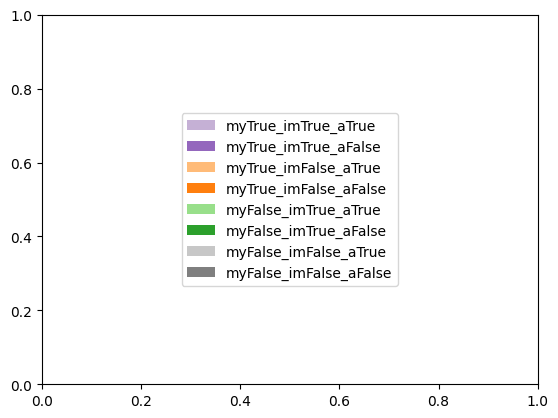

In [69]:
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=k) for k, c in cat_to_color.items()]
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

In [70]:
# rgb, meta, labeled, cat_to_color = to_cmapped_rgb_category(
#     xenium_masks[0], xenium_tiled[0, 1], xenium_tiled[0, 2],
#     myoepi_thresh=20, immune_thresh=16, area_thresh=250,
#     boundary_dist=1, external_dist=4,
# )
# plt.imshow(rgb)

In [71]:
# rgb, meta, labeled, cat_to_color = to_cmapped_rgb_category(
#     multiplex_masks[0], multiplex_tiled[0, 1], multiplex_tiled[0, 2],
#     myoepi_thresh=50, immune_thresh=18, area_thresh=250,
#     boundary_dist=1, external_dist=4,
# )
# plt.imshow(rgb)

In [73]:
# xenium_rgbs = []
# for mask, tiled in zip(xenium_masks, xenium_tiled):
#     rgb, meta, labeled, _ = to_cmapped_rgb_category(
#         mask, tiled, dtype_to_channel_idxs['xenium']['myoepi'], dtype_to_channel_idxs['xenium']['immune'],
#         myoepi_thresh=dtype_to_thresholds['xenium']['myoepi_thresh'],
#         immune_thresh=dtype_to_thresholds['xenium']['immune_thresh'],
#         area_thresh=dtype_to_thresholds['xenium']['area_thresh'],
#         boundary_dist=1, external_dist=4, cat_to_color=cat_to_color
#     )
#     plt.imshow(rgb)
#     plt.show()

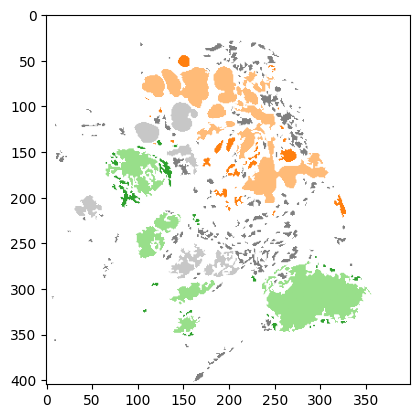

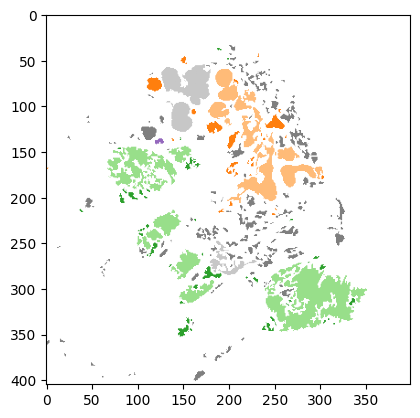

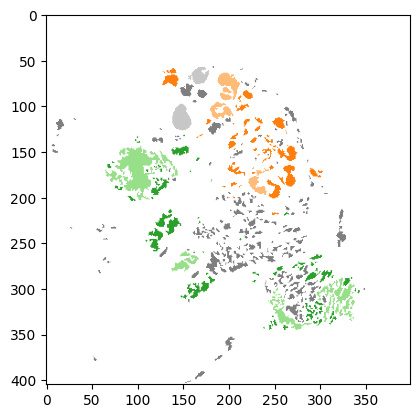

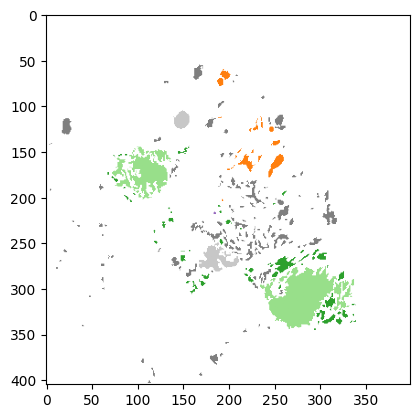

In [74]:
multiplex_rgbs = []
for mask, tiled in zip(multiplex_masks, multiplex_tiled):
    rgb, meta, labeled, _ = to_cmapped_rgb_category(
        mask, tiled, dtype_to_channel_idxs['multiplex']['myoepi'], dtype_to_channel_idxs['multiplex']['immune'],
        myoepi_thresh=dtype_to_thresholds['multiplex']['myoepi_thresh'],
        immune_thresh=dtype_to_thresholds['multiplex']['immune_thresh'],
        area_thresh=dtype_to_thresholds['multiplex']['area_thresh'],
        boundary_dist=1, external_dist=4, cat_to_color=cat_to_color
    )
    plt.imshow(rgb)
    plt.show()

In [926]:
# for x in meta.values():
#     if x['is_immune']:
#         r1, c1, r2, c2 = x['bbox_actual']
#         plt.imshow(pseudo[r1:r2, c1:c2])
#         plt.title(x['myoepi_mean'])
#         plt.show()

(405, 399) (405, 399)


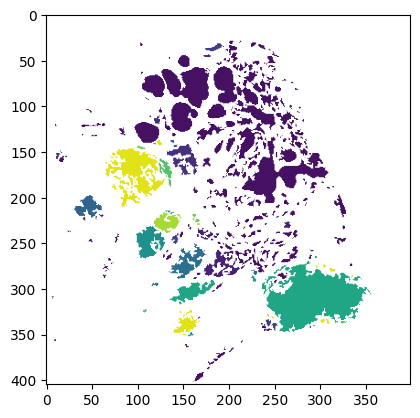

In [141]:
rgb, meta, labeled = to_cmapped_rgb_continuous(
    multiplex_masks[0], multiplex_tiled[0], 2, 10,
    boundary_dist=1, external_dist=4, method='external',
    cmap='viridis', min_area=4, vmax=.2)
plt.imshow(rgb)

(405, 399) (405, 399)
(405, 399) (405, 399)
(405, 399) (405, 399)
(405, 399) (405, 399)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


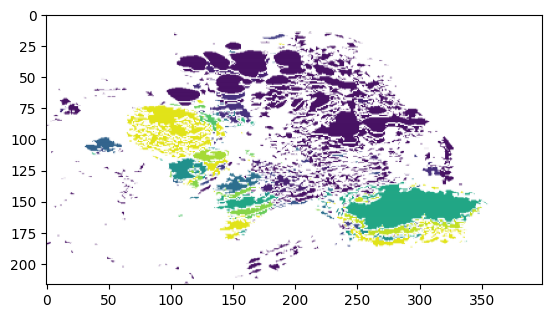

In [144]:
dtype_to_channel_idxs = {
    'multiplex': multiplex_channels.index('CD45 (D)')
}
dtype_to_thresholds = {
    'multiplex': 10
}
rgb_cont, sid_to_data_cont = to_stacked_rgb_continuous(
    case_to_config[case], dtype_to_masks, dtype_to_tiled,
    dtype_to_channel_idxs, dtype_to_thresholds,
    boundary_dist=1, external_dist=4,
    spacing_scaler=10, squish_scaler=2,
    cmap='viridis', vmax=.2, method='external'
)
plt.imshow(rgb_cont)

(405, 399) (405, 399)
(405, 399) (405, 399)
(405, 399) (405, 399)
(405, 399) (405, 399)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


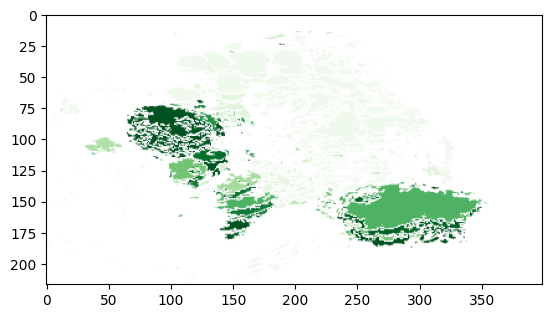

In [148]:
dtype_to_channel_idxs = {
    'multiplex': multiplex_channels.index('CD45 (D)')
}
dtype_to_thresholds = {
    'multiplex': 10
}
rgb_cont, sid_to_data_cont = to_stacked_rgb_continuous(
    case_to_config[case], dtype_to_masks, dtype_to_tiled,
    dtype_to_channel_idxs, dtype_to_thresholds,
    boundary_dist=1, external_dist=4,
    spacing_scaler=10, squish_scaler=2,
    cmap='Greens', vmax=.2, method='external'
)
plt.imshow(rgb_cont)

In [126]:
multiplex_channels

['Bap1 (D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

In [75]:
entry = next(iter(sid_to_data.values()))
entry.keys()

dict_keys(['dtype', 'rgb', 'position', 'meta', 'cat_to_color'])

In [76]:
meta = next(iter(entry['meta'].values()))
meta.keys()

dict_keys(['category', 'is_myoepi', 'is_immune', 'is_area', 'myoepi_mean', 'immune_mean', 'area', 'bbox_actual', 'prop', 'boundary_means', 'internal_means', 'external_means'])

In [78]:
dtype_to_channels = {
#     'xenium': xenium_channels,
    'multiplex': multiplex_channels
}

def get_dtype_specific_dataframe(sid_to_data, dtype):
    keys = ['category', 'is_myoepi', 'is_immune', 'is_area', 'myoepi_mean', 'immune_mean', 'area']

    columns, idxs, data = [], [], []
    
    columns += ['dtype', 'sid']
    columns += keys
    columns += ['r1', 'c1', 'r2', 'c2']
    columns += [f'boundary_{c}' for c in dtype_to_channels[dtype]]
    columns += [f'internal_{c}' for c in dtype_to_channels[dtype]]
    columns += [f'external_{c}' for c in dtype_to_channels[dtype]]
    for sid, entry in sid_to_data.items():
        if entry['dtype'] == dtype:
            for i, meta in entry['meta'].items():
                row = [dtype, sid]
                row += [meta[key] for key in keys]
                row += meta['bbox_actual']
                row += meta['boundary_means'].tolist()
                row += meta['internal_means'].tolist()
                row += meta['external_means'].tolist()
                data.append(row)
                idxs.append(i)
    df = pd.DataFrame(data=data, columns=columns, index=idxs)
    return df
            
            
        
        
        

In [79]:
def bin_dataframe(df, keep, n_bins=20, ignore=['sid', 'dtype']):
    fdf = df[keep]

#     for c in fdf.columns:
#         fdf[f'log_{c}'] = np.log1p(fdf[c])

    fdf = fdf.sort_values('myoepi_mean')
    bins = np.linspace(0, fdf['myoepi_mean'].max(), n_bins)

    # smoosh last 4 for now
    bins = bins[:-4]

    fdf['bin'] = np.digitize(fdf['myoepi_mean'], bins)
    bin_to_count = Counter(fdf['bin'])
    grouped = fdf[[c for c in fdf.columns if c not in ignore]].groupby('bin').mean()
    grouped['density'] = [bin_to_count[b] for b in grouped.index]
    return grouped, fdf

In [80]:
n_bins=20

<Axes: xlabel='myoepi_mean', ylabel='Count'>

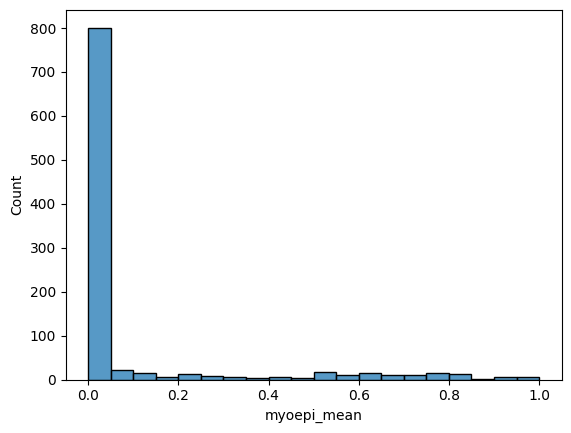

In [81]:
# df = get_dtype_specific_dataframe(sid_to_data, 'xenium')
# sns.histplot(df['myoepi_mean'], bins=n_bins)

df = get_dtype_specific_dataframe(sid_to_data, 'multiplex')
sns.histplot(df['myoepi_mean'], bins=n_bins)

In [101]:
from collections import Counter

In [82]:
# df = get_dtype_specific_dataframe(sid_to_data, 'xenium')
# keep = [
#     'dtype',
#     'sid',
#     'r1',
#     'c1',
#     'myoepi_mean',
#     'immune_mean',
#     'area',
#     'external_PTPRC',
#     'external_HLA-DQB2',
#     'external_CD68',
#     'external_CD163',
#     'external_CD8A',
#     'external_ACTA2',
#     'external_PECAM1',
# # # #     'external_GZMB',
# # #     'external_LAG3',
# ]
# order = [
#     'external_PTPRC',
#     'external_HLA-DQB2',
#     'external_CD68',
#     'external_CD163',
#     'external_CD8A',
#     'external_ACTA2',
#     'external_PECAM1',
# #     'external_GZMB',
# #     'external_LAG3',
#     'immune_mean',
#     'area',
#     'density'
# ]
# grouped, fdf = bin_dataframe(df, keep, n_bins=20)
# sns.clustermap(grouped.T.loc[order], standard_scale=0, row_cluster=False, col_cluster=False, figsize=(5, 5),
#               cmap='viridis')

In [83]:
multiplex_channels

['Bap1 (D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

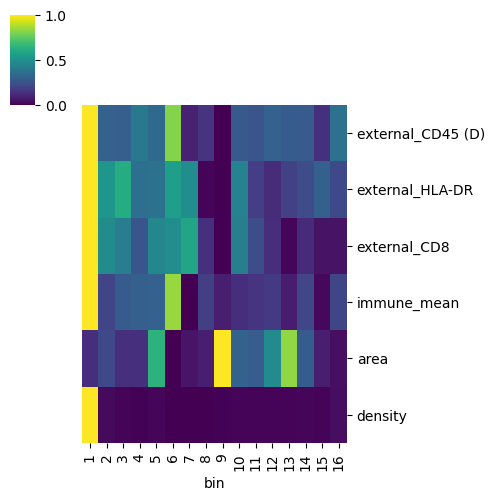

In [87]:
from collections import Counter
df = get_dtype_specific_dataframe(sid_to_data, 'multiplex')
keep = [
    'r1',
    'c1',
    'myoepi_mean',
    'immune_mean',
    'area',
    'external_CD45 (D)',
    'external_HLA-DR',
    'external_CD8',
#     'external_SMA-(D)',
    'external_Keratin 14',
]
order = [
    'external_CD45 (D)',
    'external_HLA-DR',
    'external_CD8',
#     'external_SMA-(D)',
    'immune_mean',
    'area',
    'density'
]
grouped, fdf = bin_dataframe(df, keep, n_bins=20)
sns.clustermap(grouped.T.loc[order], standard_scale=0, row_cluster=False, col_cluster=False, figsize=(5, 5),
              cmap='viridis')

(-12.600000000000001, 286.6, 316.75, -7.75)

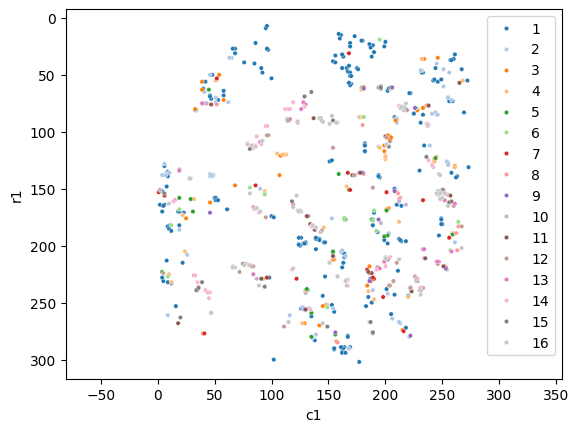

In [106]:
bins = [str(x) for x in fdf['bin']]
sns.scatterplot(data=fdf, x='c1', y='r1', hue=bins, s=10., palette='tab20')
plt.gca().invert_yaxis()
plt.axis('equal')

In [107]:
fdf

,r1,c1,myoepi_mean,immune_mean,area,external_CD68,external_HLA-DR,external_CD8,external_SMA (D),bin
4,20,180,0.000000,0.000000,54.0,2.276316,0.000000,0.000000,0.026316,1
97,135,9,0.000000,0.033333,5.0,13.433333,10.866667,1.733333,3.783333,1
102,140,195,0.000000,0.027778,10.0,13.958333,7.527778,2.847222,13.930556,1
105,148,8,0.000000,0.265625,4.0,19.515625,21.625000,3.296875,3.500000,1
107,150,208,0.000000,0.012500,10.0,17.062500,15.325000,3.025000,22.850000,1
...,...,...,...,...,...,...,...,...,...,...
93,154,245,0.916667,0.428571,4.0,23.410714,6.446429,4.357143,32.964286,16
83,138,248,0.923077,0.183824,36.0,40.132353,11.375000,4.117647,14.183824,16
111,154,248,0.926829,0.306306,20.0,10.054054,26.108108,9.135135,26.612613,16
158,227,158,0.928571,0.000000,5.0,15.066667,2.916667,0.183333,13.783333,16


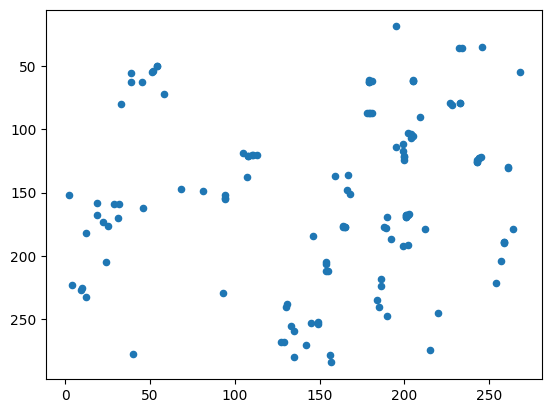

In [108]:
# plt.imshow(pseudo)
# f = fdf[fdf['sid']=='HT704B1-U1']
f = fdf
f = f[f['bin']>2]
f = f[f['bin']<7]
plt.scatter(f['c1'], f['r1'], s=20)
plt.gca().invert_yaxis()

KeyError: 'sid'

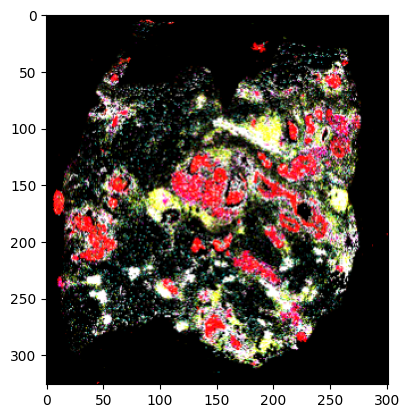

In [110]:
plt.imshow(pseudo)
f = fdf[fdf['sid']=='HT206B1-U1']
f = f[f['bin']>2]
f = f[f['bin']<7]
plt.scatter(f['c1'], f['r1'], s=20)
# plt.gca().invert_yaxis()

In [762]:
fdf

,myoepi_mean,immune_mean,area,external_PTPRC,external_HLA-DQB2,external_CD68,external_CD163,external_CD8A,external_ACTA2,external_GZMB,...,log_immune_mean,log_area,log_external_PTPRC,log_external_HLA-DQB2,log_external_CD68,log_external_CD163,log_external_CD8A,log_external_ACTA2,log_external_GZMB,bin
749,0.000000,2.350000,1.0,4.225000,2.350000,0.825000,4.950000,1.625000,2.275000,2.2,...,1.208960,0.693147,1.653455,1.208960,0.601580,1.783391,0.965081,1.186318,1.163151,1
611,0.000000,7.895833,2.0,8.083333,7.895833,6.104167,6.645833,0.520833,17.020833,0.0,...,2.185583,1.098612,2.206441,2.185583,1.960681,2.034161,0.419258,2.891528,0.000000,1
610,0.000000,14.475000,1.0,9.700000,14.475000,5.550000,4.200000,0.000000,16.400000,0.0,...,2.739226,0.693147,2.370244,2.739226,1.879465,1.648659,0.000000,2.856470,0.000000,1
614,0.000000,5.950000,1.0,6.675000,5.950000,3.425000,5.475000,1.475000,21.400000,0.0,...,1.938742,0.693147,2.037968,1.938742,1.487270,1.867949,0.906240,3.109061,0.000000,1
617,0.000000,4.867647,8.0,4.014706,4.867647,3.117647,2.838235,0.573529,10.750000,0.0,...,1.769454,2.197225,1.612375,1.769454,1.415282,1.345013,0.453321,2.463853,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,88.000000,13.200000,1.0,11.125000,13.200000,11.225000,7.100000,0.650000,29.675000,0.0,...,2.653242,0.693147,2.495269,2.653242,2.503483,2.091864,0.500775,3.423448,0.000000,16
294,89.400000,9.900000,1.0,10.875000,9.900000,6.750000,3.150000,0.000000,43.800000,0.0,...,2.388763,0.693147,2.474435,2.388763,2.047693,1.423108,0.000000,3.802208,0.000000,16
495,89.400000,8.350000,1.0,17.250000,8.350000,12.700000,9.225000,8.275000,44.025000,0.0,...,2.235376,0.693147,2.904165,2.235376,2.617396,2.324836,2.227323,3.807218,0.000000,16
474,105.727273,10.767857,3.0,14.714286,10.767857,9.517857,7.250000,3.178571,56.428571,0.0,...,2.465372,1.386294,2.754570,2.465372,2.353074,2.110213,1.429969,4.050542,0.000000,16


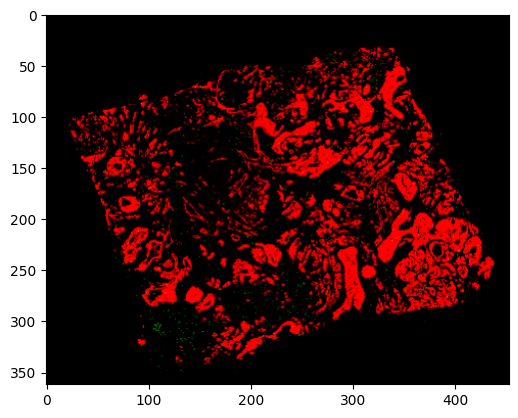

In [755]:
vs = [
    {
        'channel': 'EPCAM',
        'color': 'red',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
    {
        'channel': 'GZMB',
        'color': 'green',
        'min_value': 0,
        'max_value': 20,
        'gamma': 1.
    },
#     {
#         'channel': 'CD68',
#         'color': 'cyan',
#         'min_value': 0,
#         'max_value': 50,
#         'gamma': 1.
#     },
]
fp = '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad'
x = get_xenium_pseudo(fp, vs, tile_size=tiling_size, target_size=target_size)
plt.imshow(x)

(362, 453) (362, 453, 2)


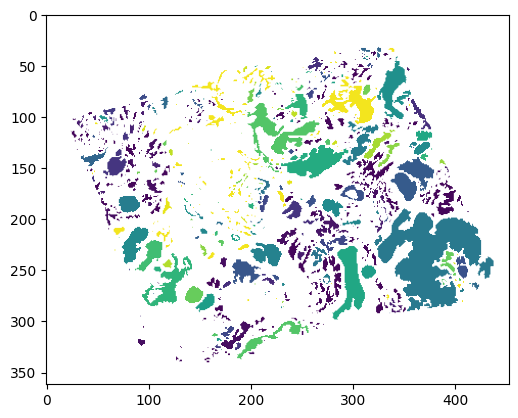

In [427]:
rgb, props = to_cmapped_rgb(masks[0], xenium_tiled[0], 1, vmax=50)
plt.imshow(rgb)

In [88]:
def to_stacked_rgb(config, dtype_to_masks, dtype_to_tiled, value_idx,
                   dtype_to_vmax=50., spacing_scaler=10, squish_scaler=2):
    target_size = next(iter(dtype_to_masks.values()))[0].shape[:2]
    dtypes = dtype_to_masks.keys()
    
    positions, sids, dts = zip(*[(entry['position'], entry['sid'], entry['data'][0]['dtype'])
                                    for entry in config['sections']
                                    if entry['data'][0]['dtype'] in dtypes])
    
    sid_to_data = {}
    for dtype in dtypes:
        intensities = dtype_to_tiled[dtype]
        masks = dtype_to_masks[dtype]
        vmax = dtype_to_vmax if not isinstance(dtype_to_vmax, dict) else dtype_to_vmax[dtype]
        ps, ids = zip(*[(p, sid) for sid, p, dt in zip(sids, positions, dts) if dt == dtype])
        for sid, mask, intensity, position in zip(ids, masks, intensities, ps):
            rgb, props = to_cmapped_rgb(mask, intensity, value_idx, vmax=vmax)
            sid_to_data[sid] = {
                'rgb': rgb,
                'position': position,
                'props': props
            }

    blank = np.zeros((target_size[-2] // squish_scaler, target_size[-1], 4))

    blank = np.concatenate(
        (blank, np.zeros((max(positions) // spacing_scaler, blank.shape[1], blank.shape[2])))
    )

    for sid in sids:
        data = sid_to_data[sid]
        rgb = data['rgb']
        position = data['position'] // spacing_scaler
        size = (rgb.shape[0] // squish_scaler, rgb.shape[1])
        rgb = utils.rescale(rgb, size=size, dim_order='h w c')

        # pad to size of blank with a translation
        top = np.zeros((position, blank.shape[1], blank.shape[2]))
        bottom = np.zeros((blank.shape[0] - (position + rgb.shape[0]), blank.shape[1], blank.shape[2]))
        padded = np.concatenate((top, rgb, bottom))

        m = blank[..., -1] == 0
        blank[m] = padded[m]

    return blank, sid_to_data

In [89]:
dtype_to_masks = {
#     'xenium': xenium_masks,
    'multiplex': multiplex_masks
}
dtype_to_tiled = {
#     'xenium': xenium_tiled,
    'multiplex': multiplex_tiled
}
img, sid_to_data = to_stacked_rgb(case_to_config[case], dtype_to_masks, dtype_to_tiled, 2)
plt.imshow(img)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 1

In [430]:
props = next(iter(sid_to_data.values()))['props']

In [441]:
means[:10]

[array([47.4137931 , 16.68965517]),
 array([45.39130435, 16.47826087]),
 array([70.625, 67.   ]),
 array([23.,  1.]),
 array([52.8, 78.6]),
 array([41.38461538,  0.53846154]),
 array([42.5,  0. ]),
 array([21., 10.]),
 array([45.9,  0.7]),
 array([28., 13.])]

10510 10510


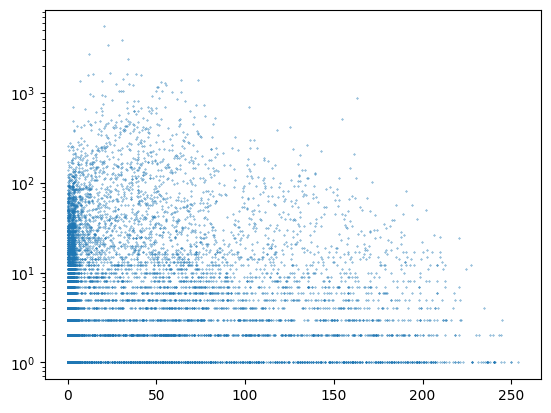

In [445]:
means, areas = [], []
for sid, data in sid_to_data.items():
    for p in data['props']:
        means.append(p.intensity_mean[1])
        areas.append(p.area)
print(len(means), len(areas))
plt.scatter(means, areas, s=.1)
ax = plt.gca()
plt.yscale('log')

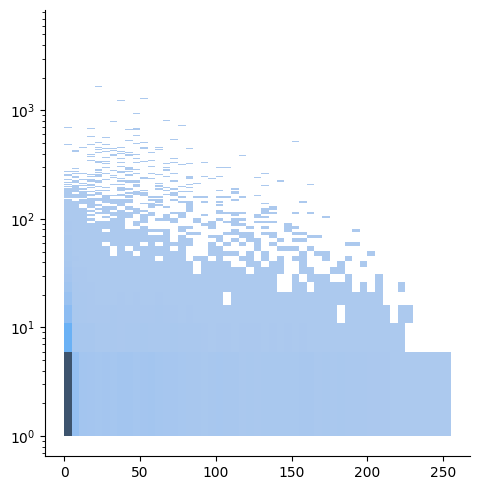

In [449]:
sns.displot(x=means, y=areas, binwidth=(5,5), )
plt.yscale('log')